### 1D Kalman Filter

In [1]:
class KalmanFilterClass(object):
    def __init__(self,name='kf',dt=0.05,q_x=0.1,q_v=0.1,r_y=1.0,y_init=0.0):
        self.name = name
        self.dt = dt
        self.q_x = q_x
        self.q_v = q_v
        self.r_y = r_y
        self.y_init = y_init
        # Initialize some internal variables
        self.Q = np.array([[self.q_x,0],[0,self.q_v]])
        self.R = np.array(self.r_y)
        self.H = np.array([[1,0]])
        self.F = np.array([[1,self.dt],[0,1]])
        #
        self.x_hat = np.array([[self.y_init],[0]])
        self.P_hat = self.Q
        self.y = self.y_init
        
    # Update Kalman Filter
    def update(self,y):
        x_hat_m = np.matmul(self.F,self.x_hat)
        P_hat_m = np.matmul(np.matmul(self.F,self.P_hat),self.F.T) + self.Q
        W = np.linalg.inv(np.matmul(np.matmul(self.H,P_hat_m),self.H.T)+self.R)
        K = np.matmul(np.matmul(P_hat_m, self.H.T),W)
        # Update
        self.x_hat = self.x_hat + np.matmul(K,y-np.matmul(self.H,x_hat_m))
        self.P_hat = P_hat_m - np.matmul(np.matmul(K,self.H),P_hat_m)

In [2]:
def signedint2int(signedints):
    signedints = np.asarray(signedints)
    plainInts = np.zeros_like(signedints)
    for idx,signedint in enumerate(signedints):
        assert 0<=signedint and signedint<2**16
        if signedint > 2**15:
            plainInt = signedint - 2**16
        else:
            plainInt = signedint
        plainInts[idx] = plainInt
    return plainInts

## open port

In [4]:
!echo 'qwer1234'| sudo -S chmod a+rw /dev/ttyUSB0

[sudo] password for terry-q: 

## BASIC USAGE OF XL320 CLASS

In [5]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import custom_dynamixel_functions as dynamixel
from datetime import datetime
from class_xc330 import xc330
from class_motionhelper import tracker, timer
# from class_grp import grp
%matplotlib inline
print ("PACKAGES LOADED.")


PACKAGES LOADED.


## INSTANTIATE XL320 

In [6]:
snapbot = xc330('SNAPBOT', _USB_NUM=0)

[SNAPBOT] INSTANTIATED AT [/dev/ttyUSB0]


## CONNECT

In [8]:
snapbot.connect()

# snapbot.IDX_LIST = [21, 22, 15, 16, 13, 14, 17, 18]

[SNAPBOT] CONNECT
 SUCCEEDED TO OPEN THE PORT!
 SUCCEEDED TO CHANGE THE BAUDRATE!
COMMUNICATION SUCCESS
[SNAPBOT] DETECT ID
[SNAPBOT] [12]MOTORS DETECTED 
[SNAPBOT] ID_LIST:[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]


In [9]:
snapbot.set_torque([1])
print ("TORQUE ON")


TORQUE ON


In [10]:
snapbot.set_operatingmode([4])


In [11]:
print ("INITIALIZE POSITION")
currpos = snapbot.get_currpos()
print (currpos)

minmaxInterval = 5000
snapbot.set_minmaxpos(currpos-np.ones_like(currpos)*minmaxInterval,currpos+np.ones_like(currpos)*minmaxInterval)

INITIALIZE POSITION
[  45 1664 3425  220 2313 1771 1469 1284  299 3699 2412 3329]


## Go to Zeropos

In [12]:
snapbot.set_goalpos(currpos)

## Calibrate

In [13]:
pos = currpos+np.array([0,0,-0,0,-0,0,-0,100,-0,0,-0,0])
snapbot.set_goalposcluster(pos,1)
cur = snapbot.get_currcurr()
# cur1 = 65536 - cur[0]
# cur2 = cur[1]
# cur3 = cur[2]
# SingleLs = np.array([cur1,cur2,cur3])
# SingleLs
cur = signedint2int(cur)
cur

array([ 0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0])

## KalmanFilter

### plot current estimation

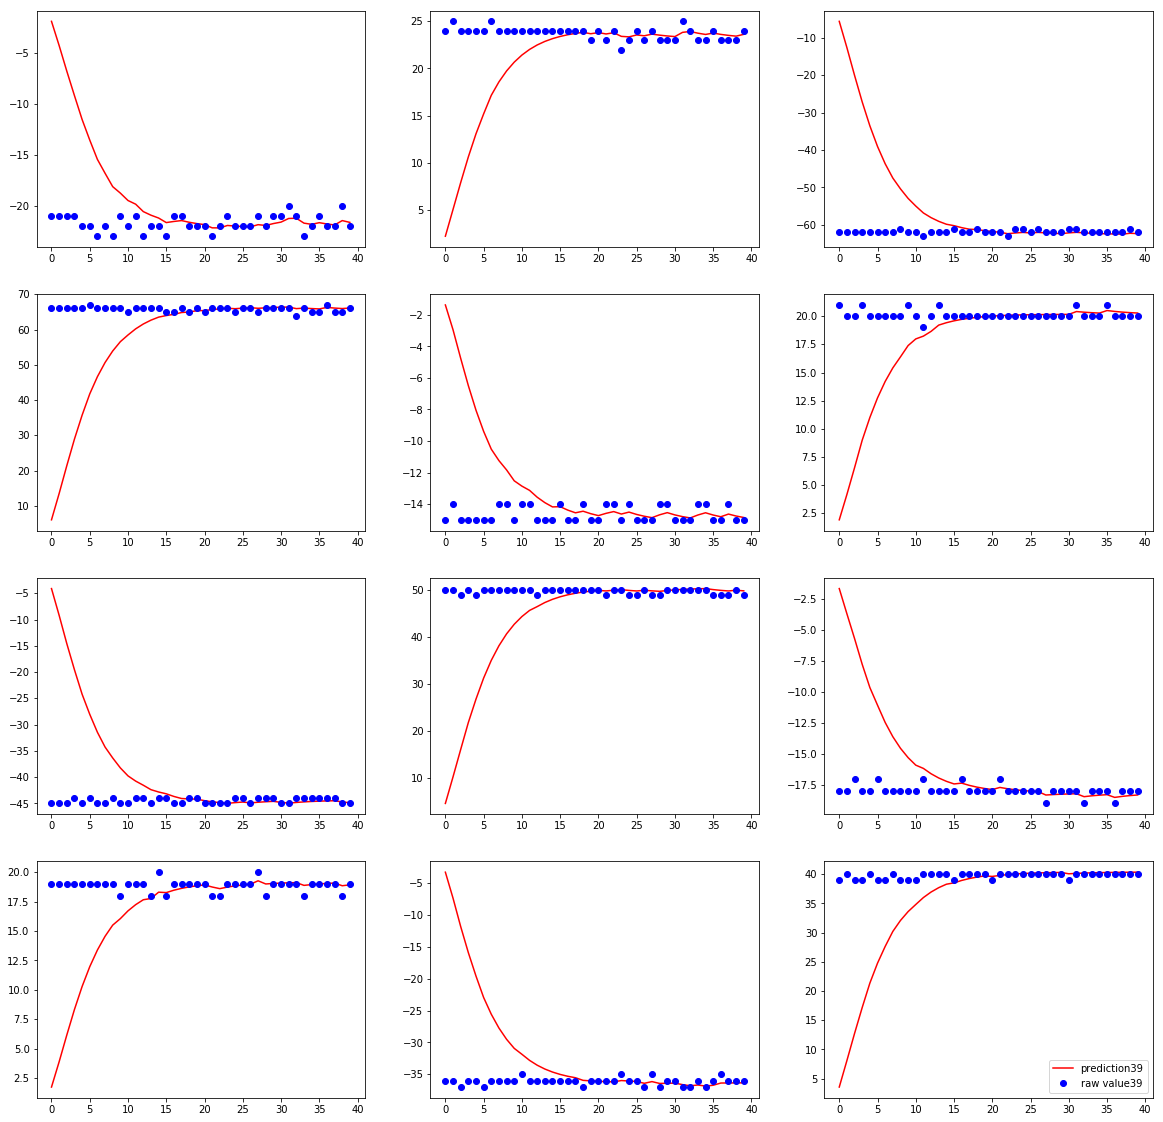

In [16]:
currpos = snapbot.get_currpos()
length = currpos.shape[0]
KalmanFilters = []
for i in range(length):
    name = "current" + str(i)
    KalmanFilter = KalmanFilterClass(name=name,dt=0.05,q_x=0.1,q_v=0.1,r_y=2.0,y_init=0.0)
    KalmanFilters.append(KalmanFilter)
#Calibrate
# ls = np.zeros(10*3).reshape(10,3)
numiter = 40
updatevalues = np.zeros(length*numiter).reshape(length,numiter)
predPlots = np.zeros(length*numiter).reshape(length,numiter)

for i in range(numiter):
    cur = snapbot.get_currcurr()
    cur = signedint2int(cur)
    
    for idx,(KalmanFilter,Singlecur) in enumerate(zip(KalmanFilters,cur)):
        updatevalues[idx,i] = Singlecur
        KalmanFilter.update(Singlecur)

        
        pred = KalmanFilter.x_hat[0] + KalmanFilter.x_hat[1]*KalmanFilter.dt*2   
        
        predPlots[idx,i] = pred
        
    time.sleep(0.1)

figure, axis = plt.subplots(4,3,figsize=(20,20))
for idx,(updatevalue,predPlot) in enumerate(zip(updatevalues,predPlots)):
    axis[idx//3,idx%3].plot(predPlot,'r-', label='prediction'+str(i))
    axis[idx//3,idx%3].plot(updatevalue,'ob',label='raw value'+str(i))

plt.legend()
plt.show()

In [12]:
snapbot.set_torque([0])
time.sleep(2)
snapbot.set_torque([1])

In [13]:
currpos = snapbot.get_currpos()
minmaxInterval = 5000
snapbot.set_minmaxpos(currpos-np.ones_like(currpos)*minmaxInterval,currpos+np.ones_like(currpos)*minmaxInterval)
initpos = snapbot.get_currpos()

In [18]:
print ("INITIALIZE POSITION")
currpos = snapbot.get_currpos()
print (currpos)

minmaxInterval = 5000
snapbot.set_minmaxpos(currpos-np.ones_like(currpos)*minmaxInterval,currpos+np.ones_like(currpos)*minmaxInterval)


currpos = snapbot.get_currpos()
length = currpos.shape[0]
numiter = 10
predPlots = np.zeros(length*numiter).reshape(length,numiter)

maxtime = 500
Errorbound = 1
# Kp = 2
# Kd = 0.02
Kp = 2
Kd = 1
currentTarget = np.array([-1,1,-1,1,-1,1,-1,1,-1,1,-1,1])*30
currentErrors = np.zeros(maxtime*length).reshape(maxtime,currentTarget.shape[0])
pos = snapbot.get_currpos()
iteration = 0
warmiteration = 100
KalmanFilters = []

# Warm up Sequence
for i in range(length):
    name = "current" + str(i)
    KalmanFilter = KalmanFilterClass(name=name,dt=0.05,q_x=0.1,q_v=0.1,r_y=2.0,y_init=0.0)
    KalmanFilters.append(KalmanFilter)

for num in range(warmiteration):
    cur = snapbot.get_currcurr()
    cur = signedint2int(cur)
    
    for idx,(KalmanFilter,Singlecur) in enumerate(zip(KalmanFilters,cur)):
        # updatevalues[idx,i] = Singlecur
        KalmanFilter.update(Singlecur)

    
        pred = KalmanFilter.x_hat[0] + KalmanFilter.x_hat[1]*KalmanFilter.dt*2
    
        # predPlots[idx,i] = pred
        
    time.sleep(0.01)
print("Warm up Done!")

while True:
    snapbot.set_torque([1])
    snapbot.set_goalpos(pos)
    
    #Calibrate
    
    
    # updatevalues = np.zeros(length*numiter).reshape(length,numiter)
    # predPlots = np.zeros(length*numiter).reshape(length,numiter)

    for i in range(numiter):
        
        cur = snapbot.get_currcurr()
        cur = signedint2int(cur)
        
        for idx,(KalmanFilter,Singlecur) in enumerate(zip(KalmanFilters,cur)):
            # updatevalues[idx,i] = Singlecur
            KalmanFilter.update(Singlecur)

        
            pred = KalmanFilter.x_hat[0] + KalmanFilter.x_hat[1]*KalmanFilter.dt*2
        
            predPlots[idx,i] = pred
    
    
    time.sleep(0.1)
    
    currentError = currentTarget - predPlots[:,-1]
    
    currentErrors[iteration] = currentError
    
    P = currentError
    
    if iteration==0:
        D = 0
    else:
        D = currentErrors[iteration] - currentErrors[iteration-1]
    
    deltaX = Kp * P - Kd * D
    deltaX = np.where(abs(currentError)<Errorbound,0,deltaX)
    print("[{:.3f},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f},\t]".format(currentError[0],currentError[1],\
        currentError[2],currentError[3],currentError[4],currentError[5],currentError[6],currentError[7],currentError[8],currentError[9],currentError[10],currentError[11],))
    
    # print(deltaX)
    # print(P,D)
    
    pos = pos+deltaX
    pos = pos.astype(np.int)
    if (abs(currentError)<Errorbound).all():
        break
    
    iteration = iteration+1
    if iteration>=maxtime:
        print("Reached maximum Iteration")
        break

print ("INITIALIZE POSITION")
currpos = snapbot.get_currpos()
print (currpos)

minmaxInterval = 5000
snapbot.set_minmaxpos(currpos-np.ones_like(currpos)*minmaxInterval,currpos+np.ones_like(currpos)*minmaxInterval)
initpos = snapbot.get_currpos()

INITIALIZE POSITION
[  698  4958    76  3196 -1393  5387 -2154  4436 -3199  7042  -734  6408]
Warm up Done!
[-16.471,	17.397,	-11.318,	14.762,	-19.502,	14.286,	-17.261,	18.639,	-18.534,	16.764,	-16.970,	20.335,	]
[10.964,	-7.607,	8.601,	-8.448,	8.178,	-5.179,	5.643,	-8.193,	9.551,	-6.219,	6.456,	-8.047,	]
[12.941,	-14.232,	14.709,	-16.680,	15.631,	-11.006,	13.477,	-17.412,	12.524,	-13.170,	11.467,	-12.362,	]
[-11.992,	8.663,	-9.285,	9.218,	-8.331,	2.357,	-4.174,	6.914,	-11.689,	9.487,	-7.214,	8.953,	]
[-13.937,	15.488,	-14.721,	16.971,	-16.473,	12.815,	-13.874,	17.238,	-14.204,	14.125,	-13.007,	13.472,	]
[8.216,	-7.948,	8.632,	-7.050,	5.052,	0.946,	0.030,	-1.174,	8.462,	-5.611,	4.807,	-6.243,	]
[11.470,	-11.434,	18.869,	-17.994,	15.688,	0.928,	0.505,	-20.996,	10.242,	-9.698,	9.196,	-9.735,	]
[-9.028,	9.190,	-8.774,	8.736,	-5.733,	-2.338,	3.608,	0.756,	-10.695,	5.407,	-7.608,	6.691,	]
[-12.659,	13.178,	-16.059,	16.812,	-16.559,	-1.307,	-0.362,	2.243,	-11.867,	11.575,	-10.194,	11.618,	]


KeyboardInterrupt: 

In [11]:
minmaxInterval = 5000
snapbot.set_minmaxpos(currpos-np.ones_like(currpos)*minmaxInterval,currpos+np.ones_like(currpos)*minmaxInterval)
initpos = snapbot.get_currpos()

In [107]:
snapbot.set_goalposcluster(initpos,1)

In [118]:
snapbot.set_torque([0])
time.sleep(2)
snapbot.set_torque([1])

In [125]:
##Custom Calibration

Calpos = initpos+np.array([-2200,1300,-1800,1200 ,-1800,1500,-1500,1500 ,-2000,1700,-1700,1300 ])
Calpos = Calpos.astype(np.int)
snapbot.set_goalposcluster(Calpos,1)

In [126]:
##Grasp

pos = Calpos+np.array([0,1,0,3]*3) * 500
pos = pos.astype(np.int)
snapbot.set_goalposcluster(pos,1)

In [38]:
##Grasp

pos = initpos+np.array([0,0,0.5,1]*3) * 2000 + np.array([-1,-0.5,0,0]*3) * 1000
pos = pos.astype(np.int)
snapbot.set_goalposcluster(pos,1)

In [86]:
##Ungrasp
pos = initpos+np.array([0,0,-1,0,0,0,-1,0,0,0,-1,0])* 0+np.array([1000,0,0,0,0,0,0,0,0,0,0,0])
snapbot.set_goalposcluster(pos,1)

In [83]:
## Init
pos = initpos
snapbot.set_goalposcluster(pos,1)

In [16]:
snapbot.LEN_GOAL_POSITION

4

In [11]:
posList = []

In [19]:
currpos = snapbot.get_currpos()
# print ("CURRENT POS: %s" % (currpos))
posList.append(currpos)
print(posList)

NameError: name 'posList' is not defined